# SUMMARY:

This notebook contains code to visualize how the sentiment (and secondarily, the content) of a given wikipedia page evolves over time. The code in this notebook has been used to answer the following questions:

1. How has the wikipedia page for the covid-19 pandemic evolved as the situation escalated in terms of A) its general sentiment, and B) its topical content. 
2. Does the sentiment on the Wikipedia pages of important figures evolve over time

To answer the sentiment component of both questions, the wikipedia histories of different pages were scraped using BeautifulSoup and analyzed using the VADER model inside the nltk package. To track the content changes for question 1, the word distribution for the covid-19 pandemic page was tracked through its different revisions and visualized using a racing barplot.

### TLDR: 
The main takeaways I have from this entire project are the following:
- It's difficult to compare the sentiment of wikipedia pages to each other. Even if wikipedia's rules try to enforce a consistent neutrality across articles, coverage of topics within those articles can give different baseline sentiment levels for different articles. Tracking the sentiment of pages using the methods in this project can only be useful insofar as they provide the relative changes of sentiment within that article.

- Using the racing barplot visualization in this project as a way to track word frequency changes within an article serves as a useful tool to analyze how the narrative and focus within an article changes over time as an article is updated with newer information. 

## Hypotheses:

1. When analyzing tracking the sentiment of the covid-19 pandemic page, we would expect negative sentiment to rise in relation to the severity of the situation
2. When analyzing the content of the word frequency for the covid-19 pandemic page, we would expect to see more negative terms to appear as the time progresses.
3. When analyzing the wikipedia page sentiment for various important figures, we'd expect the sentiment to vary as information is updated on that figure. (For example, if a scandal comes to light, their sentiment should go down.)

I personally don't expect Wikipedia page sentiment to vary that much over time given that Wikipedia has regulations in place to control the tone of its articles. I'm guessing that the only major influences that should affect a page's sentiment is the appearance of certain sections (like a "controversy" section on a popular figure, for example.) This entire test is more an exercise to see what would happen.

Given that we don't have any idea what a "normal" Wikipedia's sentiment level should be (and that trying to find out is outside the scope of this project), we're going to be more interested in the relative changes of positive and negative sentiment over time and the proportion of the positive sentiment vs negative sentiment. 

## Running the code

The code inside this notebook can be run in sequence. There are places though where the code can take some time to run (notably in the web scraping parts). To make it easier to audit the code, csv files have been provided that contain the results of the scraped content. These files can be loaded in instead of running the time-consuming web scraping parts.

## Imports

In [1]:
# Imports needed to scrape website data / retrieve the data
from bs4 import BeautifulSoup
import re
import datetime
import requests
import csv

# Imports needed for sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer

# Imports from nltk for analyzing word distibutions
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
import string


# Imports for plots
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import matplotlib.animation as animation
from IPython.display import HTML


## Code for Scraping Wikipedia page 

The code below is the general code used for scraping the history of a wikipedia article.

In [17]:
# General function for scraping the history page of a wikipedia article
def scrapePage(startLink, endLink, date):
    dateLink = date.strftime('%Y-%m-%d')
    link = startLink + dateLink + endLink
    
    # Navigation on the history menu, code to find link to latest update at a given date
    tablePage = requests.get(link)
    tableSoup = BeautifulSoup(tablePage.content, 'html.parser')
    pageLinkElement = tableSoup.find('a',class_="mw-changeslist-date")
    pageLink = "https://en.wikipedia.org" + pageLinkElement['href']
    
    # Navigation on a given page on a given date, code to extract the paragraph text
    page = requests.get(pageLink)
    soup = BeautifulSoup(page.content, 'html.parser')
    paragraphs = soup.find_all('p')
    text = ""
    for paragraph in paragraphs:
        text += (" " + paragraph.text + " ")
    results[dateLink] = text
    
    # NOTE/TODO: Extraneous metadata is sometimes included at the start and at the end of the text
    # While this doesn't impact the analysis that much given the small amount of metadata relative to
    # the content, this might be worth fixing if it causes problems later on.
    
    # NOTE/TODO: Scraping using beautifulsoup is slow given that it can only send requests one page at a time.
    # This can probably be improved using multithreading, tutorial below.
    # https://medium.com/@tjt28165/multithreading-with-web-scraping-using-beautiful-soup-4-and-pandas-c5dd4dda8fca

## Code for scraping COVID-19 Pandemic page

This process can be skipped entirely if you just want to load the scraped file. (It really does take a while)

In [ ]:
# Parameters required for the website scraping
# Details of wikipedia history page to be scraped
startLink = "https://en.wikipedia.org/w/index.php?date-range-to="
endLink = "&tagfilter=&title=COVID-19_pandemic&action=history"
# Date to begin scraping from
start = datetime.datetime.strptime("2020-01-05 00:00:00.0", '%Y-%m-%d %H:%M:%S.%f')
# Scrape lasts until date today
end = datetime.datetime.today()

# Generating list of dates to inspect, dates are saved in date_list
numdays = end - start
numweeks = int((numdays.days) / 7)
date_list = []
results = {}

for i in range(numweeks + 1):
    # Get page updates in intervals of weeks
    date_list.append(start + datetime.timedelta(days=i*7))
    
# Run page scrape function on date list
for date in date_list:
    scrapePage(startLink, endLink, date)

# Save the scraped pages to a file
w = csv.writer(open("covid19pandemichistory.csv", "w"))
w.writerow(["date", "content"])
for key, val in results.items():
    w.writerow([key, val])

## Code for loading in COVID-19 history

You can skip running this if you scraped wikipedia page. Otherwise, you need to run it for the analysis afterwards.

In [3]:
# Retrieve the file of scraped page and save to dictionary
results = {}
reader = csv.DictReader(open("covid19pandemichistory.csv"))
for row in reader:
    results[row["date"]] = row["content"]

## Sentiment analysis code

General code for the VADER sentiment analysis. While this model isn't really optimized for larger tracts of text (it was trained on tweets), it's general enough to be used for our purposes. 

In [4]:
# VADER sentiment analysis
sentiments = {}

# Function removes the citations on the wikipedia page and gets sentiment for each page
# Results are saved to sentiments dictionary
def trackSentiment():
    global sentiments
    sentiments = {}
    sia = SentimentIntensityAnalyzer()
    for key in results:
        results[key] = re.sub('\[\d+\]', '', results[key])
        sentiments[key] = sia.polarity_scores(results[key])
        
# Plotting the positive/negative sentiment over time
def plotSentiment(title): 
    time = []
    positive = []
    negative = []
    for date in sentiments:
        time.append(date)
        positive.append(sentiments[date]['pos'])
        negative.append(sentiments[date]['neg'])

    tick_spacing = 10
    fig, ax = plt.subplots(1,1)
    ax.plot(time,positive)
    ax.plot(time,negative)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.title(title, fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Sentiment', fontsize=14)
    ax.legend(['Positive', 'Negative'])
    plt.xticks(rotation = 45)
    plt.show()
        

## Sentiment over time for COVID pandemic wikipedia page

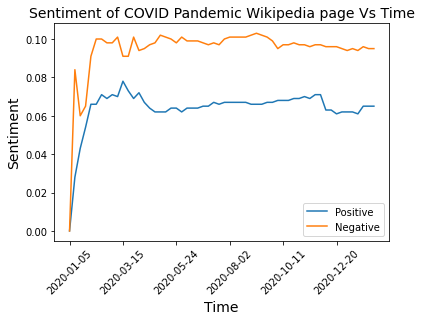

In [5]:
trackSentiment()
plotSentiment('Sentiment of COVID Pandemic Wikipedia page Vs Time')

### Analysis of output:
I initially hypothesized that the positive sentiment should rise over time as the pandemic worsens. The plot doesn't really show this. What it instead shows is that the tone starts off more or less neutral (when covid-19 was still classified as an epidemic in China), before it spikes in late january-early february, at which point it stabilizes to a point where the negative sentiment outweights the positive sentiment by a factor of 1.7.

Given that the covid-19 pandemic was exponentially worse during the latter half of 2020, we note that the sentiment plot doesn't seem to provide a good indicator of the absolute "terribleness" of a given event, but it can maybe serve as a rough indicator if it was negative or positive. 

# Code for analyzing content evolution of COVID pandemic page

The code below does the following things:
- Tokenize and process the content text of each page at a given time period
- Create a frequency distribution of words for that time period

- Create a pandas dataframe encoding the word frequency distribution per year
- Create a function to generate an animated barchart

In [6]:
# This might take (2-3 minutes)

# Removing stopwords based on nltk english package
sr= stopwords.words('english')
frequencies = {}

for key in results:
    # Processing to remove lone punctuations & non alphanumeric tokens
    tokens = [word.lower() 
              for sent in sent_tokenize(results[key]) 
              for word in word_tokenize(sent) if word.isalnum()]
    punctuation = string.punctuation + "`" + "'"
    tokens = list(filter(lambda word: word not in punctuation, tokens))
    # Processing to remove stopwords
    clean_tokens = tokens[:]
    for token in tokens:
        if token in stopwords.words('english'):
            clean_tokens.remove(token)
    freqDist = FreqDist(clean_tokens)
    frequencies[key] = freqDist

In [7]:
# Importing pandas and animation packages to create animated barchart
data = []
for date in frequencies:
    for word in frequencies[date]:
        data.append([word, date, frequencies[date][word]])
df = pd.DataFrame(data, columns = ['word', 'year', 'value'])
df.head(3)

word        year  value
0      china  2020-01-05      5
1  pneumonia  2020-01-05      5
2   outbreak  2020-01-05      4

In [11]:
# Function to create racing barchart animation
# Modified from https://towardsdatascience.com/bar-chart-race-in-python-with-matplotlib-8e687a5c8a41
group_lk = df.set_index('word').to_dict()
def draw_barchart(current_year):
    dff = df[df['year'].eq(current_year)].sort_values(by='value', ascending=True).tail(20)
    ax.clear()
    ax.barh(dff['word'], dff['value'])
    dx = dff['value'].max() / 200
    for i, (value, name) in enumerate(zip(dff['value'], dff['word'])):
        ax.text(value-dx, i,     name,           size=10, weight=600, ha='right', va='bottom')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    ax.text(1, 0.4, current_year, transform=ax.transAxes, color='#777777', size=20, ha='right', weight=800)
    ax.text(0, 1.06, 'Word Frequency', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, 'Most common words on Covid-19 Pandemic Wikipedia page over time',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    ax.text(1, 0, 'Josh Ludan; Modified code from Pratap Vardhan', transform=ax.transAxes, color='#777777', ha='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)

## The code below creates the animated barchart

The animated barchart comes with controls at the bottom.

The animated bar chart is admittedly kind of choppy. This is mostly due to the fact that the interval at which the page data comes in is at a rate of one page per week. The animation can be made much smoother if the changes were shown as they happened day by day. The fact that it's shown week by week is mostly due to the fact that it takes a long amount of time to scrape the data.

In the future, multithreading can be performed to improve the performance of BeautifulSoup and thus increase the framerate of the plot.

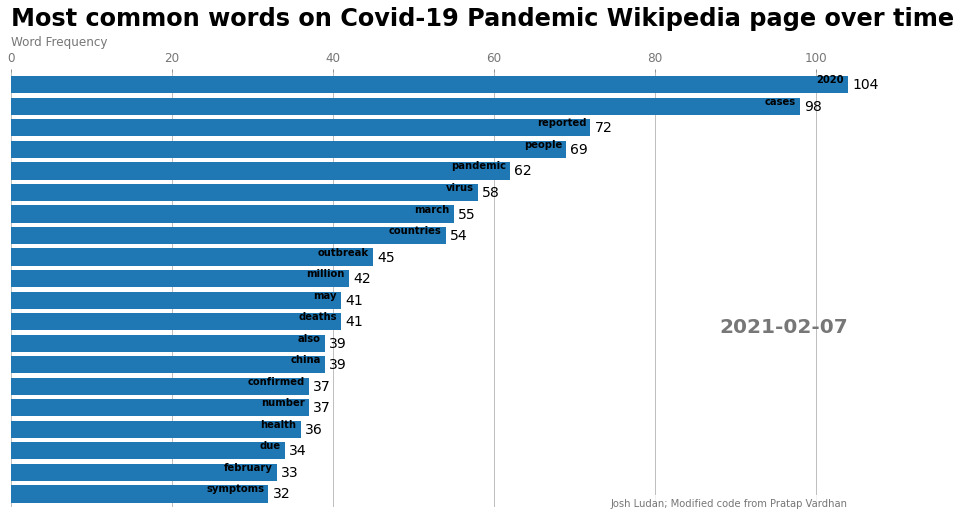

In [12]:
# Creating the animated barchart

# Code to generate y-axis. It's the same code from the scraping component
# added here in casethe data was loaded in.
start = datetime.datetime.strptime("2020-01-05 00:00:00.0", '%Y-%m-%d %H:%M:%S.%f')
end = datetime.datetime.today()
numdays = end - start
numweeks = int((numdays.days) / 7)
date_list = []
results = {}

for i in range(numweeks + 1):
    date_list.append(start + datetime.timedelta(days=i*7))
    
dates = []
for date in date_list:
    dates.append(date.strftime('%Y-%m-%d'))

fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=dates)
HTML(animator.to_jshtml())

### Analysis of output:

Looking at how which words appear to be frequent at a given point of time tells us an interesting story about how the pandemic evolved. Earlier on, we note that words such as China and Wuhan appear more relatively more frequently, since at the time covid-19 was localized to those areas. As the pandemic progresses, we note the appearance of words such as countries, millions, and death, indicating the worsening situation.

We can also track interesting patterns in the use of language. Take for example the use of the word "outbreak" in comparison to the word "pandemic". The word outbreak was used often early on while the word pandemic wasn't. Over time however, pandemic was able to overtake the word outbreak as recognition grew that covid-19 wasn't a local phenomena and was indeed a global pandemic.

This graph ended up being pretty interesting. It's a pretty cool data-driven way to analyze how the narrative around covid-19 evolved as its wikipedia page started getting updated with information. 

# Analyzing page sentiment history for different figures

## Donald Trump

Chosen because he seems like low-hanging fruit for someone whose wikipedia page is frequently updated and bound to be filled with interesting sentiments 

I'm going to be analyzing, on a month-to-month basis, the evolution of his wikipedia page sentiment from the time period of 2014 to 2021. I expect to see more negative sentiment compared to positive sentiment given the amount of criticism he's faced. Additionally, I expect this negative sentiment to rise over time (jumping around 2016)

In [ ]:
startLink = "https://en.wikipedia.org/w/index.php?date-range-to="
endLink = "&tagfilter=&title=Donald_Trump&action=history"
start = datetime.datetime.strptime("2014-01-01 00:00:00.0", '%Y-%m-%d %H:%M:%S.%f')
end = datetime.datetime.today()
numdays = end - start
numMonths = int((numdays.days) / 30)
date_list = []
results = {}

for i in range(numMonths + 1):
    date_list.append(start + datetime.timedelta(days=i*30))

for date in date_list:
    scrapePage(startLink, endLink, date)
    
w = csv.writer(open("donaldtrumphistory.csv", "w"))
w.writerow(["date", "content"])
for key, val in results.items():
    w.writerow([key, val])

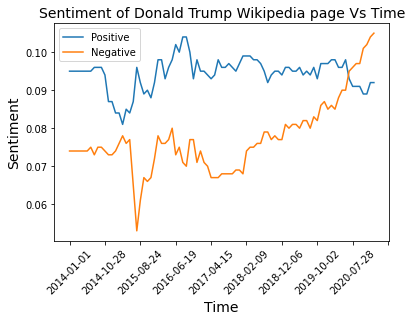

In [13]:
# Retrieve the file of scraped page and save to dictionary
results = {}
reader = csv.DictReader(open("donaldtrumphistory.csv"))
# The csv file gets big at some points, this is to prevent a field larger than field limit error.
csv.field_size_limit(100000000)
for row in reader:
    results[row["date"]] = row["content"]
    
trackSentiment()
plotSentiment('Sentiment of Donald Trump Wikipedia page Vs Time')

### Analysis of output

Contrary to my predictions, it seems that the sentiment on Trump's page is more positive than it is negative. Looking through his page's history, the case seems to be that prior to his term as president his page mostly described his popular business ventures. The negative sentiment prior to his term mostly comes from the "controversies" section on his page. The one thing that seems to agree with my prediction is the fact that his negative sentiment rose over time during his presidency, to the point that at 2020 it switched so that his negative sentiment was greater than his positive sentiment. 

## Rodrigo Duterte

Chosen out of curiosity, and to compare against Trump. Duterte is the current president of the Philippines elected in 2016 serving a 6 year term. I expect to see relatively more negative sentiment in Duterte's article compared to Trump. Additionally, I expect this negative sentiment to rise over time. 

In [ ]:
startLink = "https://en.wikipedia.org/w/index.php?date-range-to="
endLink = "&tagfilter=&title=Rodrigo_Duterte&action=history"
start = datetime.datetime.strptime("2014-01-01 00:00:00.0", '%Y-%m-%d %H:%M:%S.%f')
end = datetime.datetime.today()
numdays = end - start
numMonths = int((numdays.days) / 30)
date_list = []
results = {}

for i in range(numMonths + 1):
    date_list.append(start + datetime.timedelta(days=i*30))

for date in date_list:
    scrapePage(startLink, endLink, date)
    
w = csv.writer(open("dutertehistory.csv", "w"))
w.writerow(["date", "content"])
for key, val in results.items():
    w.writerow([key, val])

In [ ]:
# Retrieve the file of scraped page and save to dictionary
results = {}
reader = csv.DictReader(open("dutertehistory.csv"))
for row in reader:
    results[row["date"]] = row["content"]

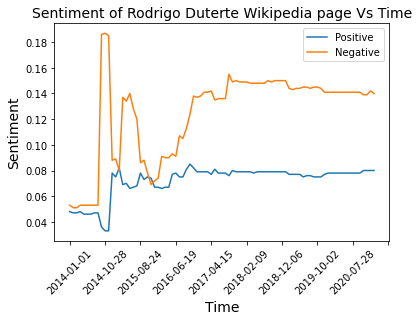

In [14]:
trackSentiment()
plotSentiment('Sentiment of Rodrigo Duterte Wikipedia page Vs Time')

### Analysis of output
The volatility of the graph during the period prior to 2016 might be due to the fact that at that point, there was little content in Duterte's wikipedia page. At which point, the addition or editing of his "controversy" section would have a lot of impact on his negative sentiment. The negative sentiment reaches a low point around late 2015, at which point it rises as more controversies pop up during Duterte's campaign. During 2017, both negative sentiment and positive sentiment plateau. This may be due to the fact that at this point, there are less major revisions. 

## Fred Rogers

Chosen to see if the sentiment on a deceased person's page would be stable given that there should be less information about them that's being updated because they're dead and no longer doing anything. My expectation would be that it should be. Additionally, I expect there to be a lot of positive sentiment compared to negative sentiment.  

In [18]:
startLink = "https://en.wikipedia.org/w/index.php?date-range-to="
endLink = "&tagfilter=&title=Fred_Rogers&action=history"
start = datetime.datetime.strptime("2014-01-01 00:00:00.0", '%Y-%m-%d %H:%M:%S.%f')
end = datetime.datetime.today()
numdays = end - start
numMonths = int((numdays.days) / 90)
date_list = []
results = {}

for i in range(numMonths + 1):
    date_list.append(start + datetime.timedelta(days=i*90))

for date in date_list:
    scrapePage(startLink, endLink, date)
    
w = csv.writer(open("rogershistory.csv", "w"))
w.writerow(["date", "content"])
for key, val in results.items():
    w.writerow([key, val])


In [ ]:
# Load in data from file
results = {}
reader = csv.DictReader(open("rogershistory.csv"))
for row in reader:
    results[row["date"]] = row["content"]

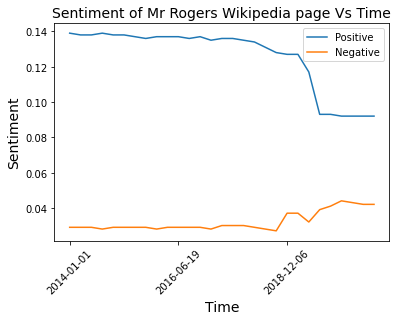

In [19]:
# Plot creation
trackSentiment()
plotSentiment('Sentiment of Mr Rogers Wikipedia page Vs Time')

### Analysis of output
Confirming my predictions, the plot shows that there is indeed a lot of positive sentiment and little negative sentiment. Additionally, the article's sentiment levels look to be stable but around early 2019 the positive sentiment dips. Looking into the page's history, it seems to be the case that there were a lot of tone edits at this period to make the article read more objectively which caused the positive sentiment to dip. 